<a href="https://colab.research.google.com/github/sharanv16/AI-Game/blob/main/AI_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Forming the Grid

Create a closed square grid

*   1 implies closed cell
*   2 implies open cell
*   4 implies bot cell
*   8 implies captain cell
*   16 implies alien cell
*   32 implies bot getting caught by alien
*   64 implies alien occupying the captain cell


# SAVING PRIVATE CAPTAIN

## IMPORTS

In [ ]:
import inspect
import matplotlib.pyplot as plt
import numpy as np
import random
import time

## CONSTANTS

In [ ]:
BOT_FAILURE = "FAIL"
BOT_SUCCESS = "SUCCESS"
BOT_STUCK = "STUCK"

X_COORDINATE_SHIFT = [1, 0, 0, -1]
Y_COORDINATE_SHIFT = [0, 1, -1, 0]

LOG_NONE = 0
LOG_INFO = 1
LOG_DEBUG = 2

CLOSED_CELL = 1
OPEN_CELL = 2
BOT_CELL = 4
CAPTAIN_CELL = 8
ALIEN_CELL = 16
BOT_CAUGHT_CELL = 32
CAPTAIN_ALIEN_CELL = 64
BOT_SUCCESS_CELL = 128
MOVED_ALIEN_CELL = 256
MOVED_ALIEN_CAPTAIN_CELL = 512
ALL_ALIEN_CELLS = CAPTAIN_ALIEN_CELL | ALIEN_CELL
MOVEMENT_CELLS = OPEN_CELL | CAPTAIN_CELL
ALIEN_MOVEMENT_CELLS = MOVEMENT_CELLS | BOT_CELL
RESCUE_PATH = MOVEMENT_CELLS | CAPTAIN_ALIEN_CELL

NO_PATH_FOUND_FLAG = -1
FINDING_PATH_FLAG = 0
GOAL_REACHED_FLAG = 1
NO_MOVES_LEFT_FLAG = 2
BOT_CAUGHT_FLAG = 3

DEAD_CELLS_CONFIG = {
    'all_cells': 1,
    'half_cells': 2
}

## GRID LOGIC



### GET NEIGHBORS

In [ ]:
"""
    Returns all adjacent cells that can be reached based on provided filter.

    Parameters
    ----------
    row_size - int
        size of the row : 10
    column_size - int
        size of the column : 10
    cell - list
        list containing x and y coordinates : (0, 0)
    filter - hex value
        filter cell based on hex value and only return those cells : 0xff
        0xff : adds all values
    grid - numpy matrix array
        grid to find adj cells details for filtering data

    Returns
    ----------
    set(list)
        Adjacent cell locations : [(1, 0), (0, 1), (2, 1), (1, 2)]
"""


def get_neighbors(row_size, column_size, cell, filter, grid):
    neighbors = []

    for i in range(4):
        x_cord = cell[0] + X_COORDINATE_SHIFT[i]
        y_cord = cell[1] + Y_COORDINATE_SHIFT[i]
        if (
            (0 <= x_cord < row_size)
            and (0 <= y_cord < column_size)
            and (grid[(x_cord, y_cord)] & filter)
        ):
            neighbors.append((x_cord, y_cord))

    return neighbors

### PLAYER PLACE AND COMMON METHODS

In [ ]:
class PlayerPlaceMethods:

    def fetch_player_cells(self):
        self.player_cells = self.fetch_cells_by_type(OPEN_CELL)

    def place_captain(self):
        self.captain_cell = self.goal = self.place_entity(CAPTAIN_CELL, True)

    def place_aliens(self):
        alien_count = self.no_of_aliens
        while alien_count:
            alien_cell = self.place_entity(ALIEN_CELL)
            self.alien_cells.append(alien_cell)
            alien_count -= 1

    def place_bot(self):
        self.bot_cell = self.start = self.place_entity(BOT_CELL)

    def place_entity(self, cell_type, skip_remove=False):
        cell = random.choice(self.player_cells)
        if self.grid[cell] == CAPTAIN_CELL:
            cell_type = CAPTAIN_ALIEN_CELL
        self.grid[cell] = cell_type
        if not skip_remove:
            self.player_cells.remove(cell)
        return cell

    def place_players(self):
        self.fetch_player_cells()
        self.place_bot()
        self.place_captain()
        self.place_aliens()

In [ ]:
class CommonShipMethods(PlayerPlaceMethods):

    def assign_base_cells(self):
        self.open_cells = self.fetch_cells_by_type(OPEN_CELL)
        self.closed_cells = self.fetch_cells_by_type(CLOSED_CELL)
        self.player_cells = self.alien_cells = []
        self.bot_cell = self.captain_cell = None

    def unblock_cell(self, cell):
        self.grid[cell] = OPEN_CELL
        self.open_cells.append(cell)
        self.closed_cells.remove(cell)

    def block_cell(self, cell):
        self.grid[cell] = CLOSED_CELL
        self.closed_cells.append(cell)
        self.open_cells.remove(cell)

    def fetch_cells_by_type(self, cell_type):
        return list(zip(*np.where(self.grid == cell_type)))

    def show_grid(self):
        print(self.grid)

### PARENT SHIP

In [ ]:
class ParentShip(CommonShipMethods):
    """ """

    def __init__(self, grid_size, no_of_aliens, *options):
        self.grid_size = grid_size
        self.no_of_aliens = no_of_aliens
        self.initialize_grid()
        self.row_size, self.column_size = self.grid.shape
        self.assign_base_cells()
        self.options = options

    def initialize_grid(self):
        """ """
        self.grid = np.full((self.grid_size, self.grid_size), OPEN_CELL)

    def generate_grid(self):
        """ """

### NORMAL SHIP

In [ ]:
class Ship(ParentShip):
    """
    Requires:
    grid_size(D) -
    no_of_aliens(K) -
    """

    static_var = 0

    def __init__(self, grid_size, no_of_aliens):
        super(Ship, self).__init__(grid_size, no_of_aliens)
        self.x_start = self.y_start = None

    ### GRID GENERATION METHODS ###

    def initialize_grid(self):
        self.grid = np.full((self.grid_size, self.grid_size), CLOSED_CELL)

    def dead_cells_config(self):
        return DEAD_CELLS_CONFIG['half_cells']

    def generate_grid(self):
        self.assign_start_cell()
        self.unblock_closed_cells()
        self.unblock_dead_ends()

    def assign_start_cell(self):
        self.x_start = random.randint(0, self.grid_size - 1)
        self.y_start = random.randint(0, self.grid_size - 1)
        self.unblock_cell((self.x_start, self.y_start))

    def unblock_closed_cells(self):
        available_cells = self.cells_with_one_open_neighbor(self.closed_cells)
        while available_cells:
            closed_cell = random.choice(available_cells)
            self.unblock_cell(closed_cell)
            available_cells = self.cells_with_one_open_neighbor(self.closed_cells)

    def unblock_dead_ends(self):
        dead_end_cells = self.cells_with_one_open_neighbor(self.open_cells)
        half_len = len(dead_end_cells) // self.dead_cells_config()

        while half_len:

            dead_end_cells = self.cells_with_one_open_neighbor(self.open_cells)
            half_len -= 1
            if len(dead_end_cells) == 0: continue
            dead_end_cell = random.choice(dead_end_cells)
            closed_neighbors = get_neighbors(
                self.row_size, self.column_size, dead_end_cell, CLOSED_CELL, self.grid
            )

            random_cell = random.choice(closed_neighbors)
            self.unblock_cell(random_cell)

    def cells_with_one_open_neighbor(self, cells):
        results = []
        for cell in cells:
            no_of_open_neighbors = len(
                get_neighbors(
                    self.row_size, self.column_size, cell, OPEN_CELL, self.grid
                )
            )
            if no_of_open_neighbors == 1:
                results.append((cell[0], cell[1]))
        return results

### BONUS SHIPS

In [ ]:
class BonusShipV1(ParentShip):

    def __init__(self, grid_size, no_of_aliens):
        super(BonusShipV1, self).__init__(grid_size, no_of_aliens)

    ### GRID GENERATION METHODS ###

    def generate_grid(self):
        self.block_alternate_cells()

    def block_alternate_cells(self):
        alternate_cells = [
            (row, col)
            for row in range(len(self.grid))
            for col in range(len(self.grid[0]))
            if row & 1 and col & 1
        ]
        for cell in alternate_cells:
            self.block_cell(cell)

In [ ]:
class BonusShipV2(Ship):

    def __init__(self, grid_size, no_of_aliens):
        super(BonusShipV2, self).__init__(grid_size, no_of_aliens)

    def dead_cells_config(self):
        return DEAD_CELLS_CONFIG['all_cells']

## VISUALIZING THE GRID

In [ ]:
def show_color_grid(grid):
    color_map = {
        CLOSED_CELL: "black",
        OPEN_CELL: "white",
        BOT_CELL: "blue",
        CAPTAIN_CELL: "green",
        ALIEN_CELL: "red",
        BOT_CAUGHT_CELL: "cyan",
        CAPTAIN_ALIEN_CELL: "magenta",
        BOT_SUCCESS_CELL: "yellow",
        MOVED_ALIEN_CELL: "red",
    }

    # Create the figure and axes
    fig, ax = plt.subplots()

    # Define cell width and height
    cell_width = 1
    cell_height = 1

    row_size, col_size = grid.shape

    # Fill the cells with the "x" pattern
    for i in range(row_size):
        for j in range(col_size):
            color = color_map[grid[i][j]]
            x = j * cell_width
            y = (row_size - i - 1) * cell_height
            ax.plot(
                [x, x + cell_width, x + cell_width, x],
                [y, y + cell_height, y, y + cell_height],
                color=color,
                linewidth=2,
            )

    # Draw black borders around each cell
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            ax.plot([j, j + 1], [i, i], color="black", linewidth=1)
            ax.plot([j, j + 1], [i + 1, i + 1], color="black", linewidth=1)
            ax.plot([j, j], [i, i + 1], color="black", linewidth=1)
            ax.plot([j + 1, j + 1], [i, i + 1], color="black", linewidth=1)

    # Set limits and labels
    ax.set_xlim(0, col_size * cell_width)
    ax.set_ylim(0, row_size * cell_height)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # Turn off axes
    ax.axis("off")

    # Show the plot
    plt.show()

## CONSTRAINTS

In [ ]:
class Constraints:
    def __init__(
        self,
        queue_size=-1,
        bot_max_moves=1000,
        max_search_time=-1,
        reduce_search_frequenzy=False,
    ):
        self.queue_size = queue_size
        self.bot_max_moves = bot_max_moves
        self.reduce_search_frequenzy = reduce_search_frequenzy
        self.max_search_time = max_search_time

## BOT LOGIC

### SEARCH ALGORITHM

In [ ]:
class Search_Algorithm:
    def __init__(self, ship, constraints, log_level):
        self.constraints = constraints
        self.local_ship = ship
        self.local_grid = np.copy(ship.grid)
        self.curr_pos = self.start_cell = ship.start
        self.captain_cell = ship.goal
        self.row_size = ship.row_size
        self.column_size = ship.column_size
        self.path_pos = 0
        self.log_level = log_level

    """
        Virtual Class that verifies if the neighbor was already visited.
        Additional conditions can be implemented in the child class.

        Parameters
        ----------
            neighbor - list
                list containing x and y cord : (0,0)
            visited_cells - set(list)
                set containing all the visited cells : [(0,0), (1,1), ...]

        Returns
        ----------
        boolean
            returns true if neighbor can be added to queue : true/false
    """

    def is_add_neighbor(self, grid_copy, neighbor, path_traversed):
        return neighbor not in self.visited_cells

    """
        Return the Shortest path from Bot cell to Captain cell

        Parameters
        ----------
            itr_completed - int
                no of moves completed by bot (movement + idle)
            grid_copy - numpy matrix array (optional)
                contains a copy of grid to find the shortest path, uses local copy of grid by default

        Returns
        ----------
        set(list)
            returns the shortest path found : [(0, 0), (0, 1), (1, 1), ... (x, y)]
    """

    def find_shortest_path(self, itr_count, neighbor_filter, grid_copy=None):
        bfs_queue = []
        self.visited_cells = set()
        self.path_pos = 0

        if grid_copy is None:
            grid_copy = self.local_grid

        # queue - [ (current_cell, (... path_traversed ...)), ... ]
        bfs_queue.append((self.curr_pos, [self.curr_pos]))

        while bfs_queue:
            current_cell, path_traversed = bfs_queue.pop(0)

            self.log_data(
                LOG_DEBUG,
                "current_cell",
                type(current_cell),
                len(current_cell),
                current_cell,
            )
            self.log_data(
                LOG_DEBUG,
                "path_traversed",
                type(path_traversed),
                len(path_traversed),
                path_traversed,
            )

            if current_cell == self.captain_cell:
                self.log_data(
                    LOG_DEBUG,
                    f"Iterations Completed : {itr_count}\tPath Length : {len(path_traversed)}\tBot Path : {path_traversed}",
                )
                return path_traversed
            elif current_cell in self.visited_cells:
                continue

            self.visited_cells.add(current_cell)
            self.log_data(
                LOG_DEBUG,
                "visited_cells",
                type(self.visited_cells),
                len(self.visited_cells),
                self.visited_cells,
            )

            current_cell_neighbors = get_neighbors(
                self.row_size,
                self.column_size,
                current_cell,
                neighbor_filter,
                grid_copy,
            )

            for neighbor in current_cell_neighbors:
                if (
                    self.constraints.queue_size == -1
                    or len(bfs_queue) <= self.constraints.queue_size
                ) and (self.is_add_neighbor(grid_copy, neighbor, path_traversed)):
                    bfs_queue.append((neighbor, path_traversed + [neighbor]))

        return None

    def sort_neighbors_by_alien(self, neighbor_cells, grid_copy):
        safest_neighbor = []
        for neighbor in neighbor_cells:
            adj_alien_cell_len = len(
                get_neighbors(
                    self.row_size,
                    self.column_size,
                    neighbor,
                    ALL_ALIEN_CELLS,
                    grid_copy,
                )
            )
            adj_alien_movements_len = len(
                get_neighbors(
                    self.row_size,
                    self.column_size,
                    neighbor,
                    MOVED_ALIEN_CELL | MOVED_ALIEN_CAPTAIN_CELL,
                    grid_copy,
                )
            )
            safest_neighbor.append(
                (neighbor, adj_alien_cell_len, adj_alien_movements_len)
            )

        safest_neighbor = sorted(
            sorted(safest_neighbor, key=lambda x: x[2]),
            key=lambda x: x[1],
        )

        return safest_neighbor

    def escape_to_nearest_open_cell(self, itr_count, grid_copy):
        neighbor_cells = get_neighbors(
            self.row_size,
            self.column_size,
            self.curr_pos,
            OPEN_CELL,
            grid_copy,
        )

        if len(neighbor_cells) == 0:
            return None

        safest_neighbor = self.sort_neighbors_by_alien(neighbor_cells, grid_copy)
        escape_path = [self.curr_pos, safest_neighbor[0][0]]
        self.log_data(
            LOG_DEBUG,
            f"Iterations Completed : {itr_count}\tEscape Path : {escape_path}",
        )

        return escape_path

    def escape_path_with_least_aliens(self, itr_count, grid_copy):
        adj_alien_movements = get_neighbors(
            self.row_size,
            self.column_size,
            self.curr_pos,
            MOVED_ALIEN_CAPTAIN_CELL,
            grid_copy,
        )

        if len(adj_alien_movements) > 0:  # handling edge cases, if any
            cap_path = [self.curr_pos, adj_alien_movements[0]]
            self.log_data(
                LOG_DEBUG,
                f"Iterations Completed : {itr_count}\tEscape Path : {cap_path}",
            )
            return cap_path

        adj_alien_movements = get_neighbors(
            self.row_size,
            self.column_size,
            self.curr_pos,
            MOVED_ALIEN_CELL,
            grid_copy,
        )
        if len(adj_alien_movements) == 0:
            return None

        safest_neighbor = self.sort_neighbors_by_alien(adj_alien_movements, grid_copy)
        escape_path = [self.curr_pos, safest_neighbor[0][0]]
        self.log_data(
            LOG_DEBUG,
            f"Iterations Completed : {itr_count}\tEscape Path : {escape_path}",
        )

        return escape_path

    def escape_nearby_aliens(self, itr_count, grid_copy):
        self.path_pos = 0

        if not (grid_copy[self.curr_pos] & BOT_CAUGHT_CELL):
            return None

        safe_path = self.escape_to_nearest_open_cell(itr_count, grid_copy)

        if safe_path is None:
            safe_path = self.escape_path_with_least_aliens(itr_count, grid_copy)

        return safe_path

### PARENT BOT

In [ ]:
class Parent_Bot(Search_Algorithm):
    def __init__(self, ship, constraints, log_level):
        super(Parent_Bot, self).__init__(ship, constraints, log_level)
        self.bot_path = [self.start_cell]
        self.alien_cells = ship.alien_cells.copy()
        self.visited_cells = self.bot_caught_cell = self.path = None
        self.idle_moves = self.bot_moves = 0
        self.status = BOT_FAILURE
        self.flag = FINDING_PATH_FLAG
        self.time_start = self.time_end = self.time_elapsed = 0

    def log_data(self, log_level, *args):
        if (self.log_level) and (log_level <= self.log_level):
            # print( self.__class__.__name__, "::", inspect.currentframe().f_back.f_code.co_name, "::", inspect.currentframe().f_back.f_lineno, "::", sep="", end="")
            print(*args)

    def display_grid(self, log_level):
        if (self.log_level) and (log_level <= self.log_level):
            self.log_data(LOG_INFO, self.local_grid)

    def start_timer(self):
        self.time_start = time.process_time_ns()

    def end_timer(self):
        self.time_end = time.process_time_ns()
        self.time_elapsed = self.time_end - self.time_start
        return self.time_elapsed

    def is_stop_search(self):
        if (self.constraints.max_search_time != -1) and (
            self.end_timer() > self.constraints.max_search_time
        ):
            return True

        self.bot_moves += 1
        if self.bot_moves > self.constraints.bot_max_moves:
            self.flag = NO_MOVES_LEFT_FLAG
            return True
        return False

    def move_bot(self):
        self.path_pos += 1
        next_cell = self.path[self.path_pos]
        retVal = False

        next_cell_val = self.local_grid[next_cell]
        if (next_cell_val & (ALIEN_CELL | CAPTAIN_ALIEN_CELL)):
            self.flag = BOT_CAUGHT_FLAG
            self.bot_caught_cell = next_cell
            self.local_grid[next_cell] = BOT_CAUGHT_CELL
            retVal = True
        elif next_cell_val & CAPTAIN_CELL:
            self.flag = GOAL_REACHED_FLAG
            self.local_grid[next_cell] = BOT_SUCCESS_CELL
            retVal = True
        else:
            self.local_grid[next_cell] = BOT_CELL

        self.local_grid[self.curr_pos] = OPEN_CELL
        self.curr_pos = next_cell
        self.bot_path.append(next_cell)

        return retVal

    def move_aliens(self):
        random.shuffle(self.alien_cells)

        for itr, alien in enumerate(self.alien_cells):
            alien_moves_possible = get_neighbors(
                self.row_size,
                self.column_size,
                alien,
                ALIEN_MOVEMENT_CELLS,
                self.local_grid,
            )
            self.log_data(
                LOG_DEBUG, f"Alien {itr, alien} has moves {alien_moves_possible}"
            )

            if len(alien_moves_possible) == 0:
                self.log_data(
                    LOG_DEBUG,
                    f"Alien {itr, alien} has no moves",
                )
                continue

            alien_new_cell = random.choice(alien_moves_possible)

            if self.local_grid[alien_new_cell] & BOT_CELL:
                self.log_data(
                    LOG_DEBUG,
                    f"Alien moves from current cell {itr, alien} to bot cell {alien_new_cell}",
                )
                self.flag = BOT_CAUGHT_FLAG
                self.bot_caught_cell = alien_new_cell
                self.local_grid[alien_new_cell] = BOT_CAUGHT_CELL
                self.local_grid[alien] = OPEN_CELL
                return True
            elif self.local_grid[alien_new_cell] & CAPTAIN_CELL:
                self.log_data(
                    LOG_DEBUG,
                    f"Alien moves from current cell {itr, alien} to captain cell {alien_new_cell}",
                )
                self.local_grid[alien_new_cell] = CAPTAIN_ALIEN_CELL
                self.local_grid[alien] = OPEN_CELL
            else:
                if self.local_grid[alien] & CAPTAIN_ALIEN_CELL:
                    self.log_data(
                        LOG_DEBUG,
                        f"Alien moves from captain cell {itr, alien, self.local_grid[alien]} to open cell {alien_new_cell}",
                    )
                    self.local_grid[alien] = CAPTAIN_CELL
                else:
                    self.log_data(
                        LOG_DEBUG,
                        f"Alien moves from current cell {itr, alien, self.local_grid[alien]} to open cell {alien_new_cell}",
                    )
                    self.local_grid[alien] = OPEN_CELL
                self.local_grid[alien_new_cell] = ALIEN_CELL

            # Update alien_cells with new location
            self.alien_cells[itr] = alien_new_cell

        return False

    def print_rescue_status(self):
        if self.flag == GOAL_REACHED_FLAG:
            self.log_data(LOG_INFO, "Goal Reached!!")
            self.status = BOT_SUCCESS
        elif self.flag == NO_MOVES_LEFT_FLAG:
            self.log_data(LOG_INFO, "Bot is stuck, no moves left!!")
            self.display_grid(LOG_INFO)
            self.status = BOT_STUCK
        elif self.flag == BOT_CAUGHT_FLAG:
            self.log_data(LOG_INFO, "RIP Bot!!")
            self.log_data(LOG_INFO, f"Alien caught bot at {self.bot_caught_cell}")
        elif self.flag == NO_PATH_FOUND_FLAG:
            self.log_data(LOG_INFO, "No path found!!")
        else:
            self.log_data(LOG_INFO, "Unknown error occurred!!")

    def print_rescue_output(self):
        self.end_timer()
        self.print_rescue_status()
        self.log_data(LOG_INFO, self.bot_path)
        self.log_data(LOG_INFO, f"no of steps taken = {len(self.bot_path)}")
        if self.idle_moves:
            self.log_data(LOG_INFO, f"no of idle moves = {self.idle_moves}")
        self.log_data(LOG_INFO, f"total iterations = {self.bot_moves}")

### BOT 1


In [ ]:
class Bot_1(Parent_Bot):
    def __init__(self, ship, constraints, log_level=LOG_INFO):
        super(Bot_1, self).__init__(ship, constraints, log_level)

    def start_rescue(self):
        self.start_timer()
        self.path = self.find_shortest_path(self.bot_moves, RESCUE_PATH | ALIEN_CELL)

        if self.path is None:
            self.flag = NO_PATH_FOUND_FLAG
        else:
            while self.flag == FINDING_PATH_FLAG:
                if self.is_stop_search():
                    break

                self.display_grid(LOG_DEBUG)
                if self.move_bot():
                    break

                if self.move_aliens():
                    self.display_grid(LOG_DEBUG)
                    break

        self.print_rescue_output()

### BOT 2

In [ ]:
class Bot_2(Parent_Bot):
    def __init__(self, ship, constraints, log_level=LOG_INFO):
        super(Bot_2, self).__init__(ship, constraints, log_level)

    def is_recalculate_path(self):
        return (self.path is None) or (self.path in self.alien_cells)

    def start_rescue(self):
        self.start_timer()
        while self.flag == FINDING_PATH_FLAG:
            if self.is_stop_search():
                break

            if (
                not self.constraints.reduce_search_frequenzy
                or self.is_recalculate_path()
            ):
                self.path = self.find_shortest_path(self.bot_moves, MOVEMENT_CELLS)

            self.display_grid(LOG_DEBUG)
            if self.path is None:
                self.idle_moves += 1
            elif self.move_bot():
                break

            if self.move_aliens():
                self.display_grid(LOG_DEBUG)
                break

        self.print_rescue_output()

### BOT 3

In [ ]:
class Bot_3(Bot_2):
    def __init__(self, ship, constraints, log_level=LOG_INFO):
        super(Bot_3, self).__init__(ship, constraints, log_level)

    def clone_grid_with_alien_moves(self):
        clone_grid = np.copy(self.local_grid)

        for alien in self.alien_cells:
            adj_cells = get_neighbors(
                self.row_size, self.column_size, alien, MOVEMENT_CELLS, self.local_grid
            )
            for cell in adj_cells:
                clone_grid[cell] = (
                    MOVED_ALIEN_CELL
                    if clone_grid[cell] & OPEN_CELL
                    else MOVED_ALIEN_CAPTAIN_CELL
                )

        return clone_grid

    def start_rescue(self):
        self.start_timer()
        while self.flag == FINDING_PATH_FLAG:
            if self.is_stop_search():
                break

            if (
                not self.constraints.reduce_search_frequenzy
            ) or self.is_recalculate_path():
                grid_alien_move_copy = self.clone_grid_with_alien_moves()
                self.path = self.find_shortest_path(
                    self.bot_moves, MOVEMENT_CELLS, grid_alien_move_copy
                )
                if self.path is None:
                    self.path = self.find_shortest_path(self.bot_moves, MOVEMENT_CELLS)
                    if self.path is None:
                        self.idle_moves += 1

            self.display_grid(LOG_DEBUG)
            if (self.path is not None) and (self.move_bot()):
                break

            if self.move_aliens():
                self.display_grid(LOG_DEBUG)
                break

        self.print_rescue_output()

### BOT 4

In [ ]:
class Bot_4(Bot_3):
    def __init__(self, ship, constraints, log_level=LOG_INFO):
        super(Bot_4, self).__init__(ship, constraints, log_level)
        self.is_escape_path = False

    def clone_grid_with_alien_moves(self):
        clone_grid = np.copy(self.local_grid)

        for alien in self.alien_cells:
            adj_cells = get_neighbors(
                self.row_size,
                self.column_size,
                alien,
                MOVEMENT_CELLS | BOT_CELL,
                self.local_grid,
            )
            for cell in adj_cells:
                if clone_grid[cell] & OPEN_CELL:
                    clone_grid[cell] = MOVED_ALIEN_CELL
                elif clone_grid[cell] & CAPTAIN_CELL:
                    clone_grid[cell] = MOVED_ALIEN_CAPTAIN_CELL
                else:
                    clone_grid[cell] = BOT_CAUGHT_CELL

        return clone_grid

    def is_add_neighbor(self, grid_copy, neighbor, path_traversed):
        ## BOT 4 V2 Logic
        if len(path_traversed) < 6 and grid_copy[neighbor] & (
            ALL_ALIEN_CELLS | MOVED_ALIEN_CELL | MOVED_ALIEN_CAPTAIN_CELL
        ):
            return False

        return super(Bot_4, self).is_add_neighbor(grid_copy, neighbor, path_traversed)

    def is_recalculate_path(self):
        if self.path is None:
            return True

        is_cap_next_pos = self.path_pos + 1
        if (is_cap_next_pos > len(self.path)) and (
            self.local_grid[self.path[is_cap_next_pos]] & CAPTAIN_CELL
        ):
            return False

        for itr in range(1, 5, 1):
            next_pos = self.path_pos + 1
            if next_pos < len(self.path):
                if self.path[next_pos] in self.alien_cells:
                    return True

                adj_cells_for_next_move = get_neighbors(
                    self.row_size,
                    self.column_size,
                    self.path[next_pos],
                    ALL_ALIEN_CELLS,
                    self.local_grid,
                )
                if adj_cells_for_next_move in self.alien_cells:
                    return True

        return False

    def start_rescue(self):
        self.start_timer()
        while self.flag == FINDING_PATH_FLAG:
            if self.is_stop_search():
                break

            if (
                (not self.constraints.reduce_search_frequenzy)
                or self.is_escape_path
                or self.is_recalculate_path()
            ):
                self.is_escape_path = False
                grid_alien_move_copy = self.clone_grid_with_alien_moves()

                ## BOT 4 V1 Logic
                # self.path = self.find_shortest_path(
                #     self.bot_moves, MOVEMENT_CELLS, grid_alien_move_copy
                # )

                ## BOT 4 V2 Logic
                self.path = self.find_shortest_path(
                    self.bot_moves, RESCUE_PATH | MOVED_ALIEN_CAPTAIN_CELL | MOVED_ALIEN_CELL | ALIEN_CELL, grid_alien_move_copy
                )
                if self.path is None:
                    self.path = self.escape_nearby_aliens(
                        self.bot_moves, grid_alien_move_copy
                    )
                    if self.path is None:
                        self.idle_moves += 1  # Sit and pray
                    else:
                        self.is_escape_path = True

            self.display_grid(LOG_DEBUG)

            if (self.path is not None) and (self.move_bot()):
                break

            if self.move_aliens():
                self.display_grid(LOG_DEBUG)
                break

        self.print_rescue_output()

## MAIN

In [ ]:
ship = Ship(30, 10)
ship.generate_grid()
ship.place_players()
# constraints = Constraints()
constraints = Constraints(
    int(len(ship.player_cells) * 2 / 3),
    int(ship.grid.shape[0] * ship.grid.shape[1] * 0.8),
    -1,
    True,
)

[[2 2 2 ... 2 2 2]
 [2 2 1 ... 1 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 1 ... 2 2 1]
 [2 1 2 ... 1 2 2]
 [1 2 2 ... 2 2 2]]


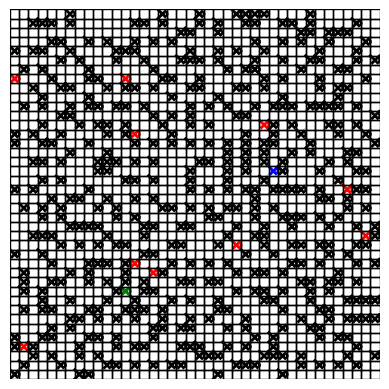

bot position (17, 28)	captain position (30, 12)
distance = 20.615528128088304


In [ ]:
ship.show_grid()
show_color_grid(ship.grid)
print(f"bot position {ship.start}\tcaptain position {ship.goal}")
print(
    f"distance = {np.sqrt((ship.start[0] - ship.goal[0])**2 + (ship.start[1]-ship.goal[1])**2)}"
)

In [ ]:
bot1 = Bot_1(ship, constraints)
bot1.start_rescue()

Goal Reached!!
[(17, 28), (17, 27), (17, 26), (18, 26), (18, 25), (18, 24), (19, 24), (20, 24), (20, 23), (20, 22), (20, 21), (20, 20), (21, 20), (22, 20), (23, 20), (24, 20), (25, 20), (26, 20), (26, 19), (26, 18), (26, 17), (26, 16), (27, 16), (27, 15), (28, 15), (28, 14), (28, 13), (29, 13), (30, 13), (30, 12)]
no of steps taken = 30
total iterations = 29


In [ ]:
bot2 = Bot_2(ship, constraints)
bot2.start_rescue()

Goal Reached!!
[(17, 28), (17, 27), (17, 26), (18, 26), (18, 25), (18, 24), (19, 24), (20, 24), (20, 23), (20, 22), (20, 21), (20, 20), (21, 20), (22, 20), (23, 20), (24, 20), (25, 20), (26, 20), (26, 19), (26, 18), (26, 17), (26, 16), (27, 16), (27, 15), (27, 14), (28, 14), (28, 13), (29, 13), (30, 13), (30, 12)]
no of steps taken = 30
total iterations = 29


In [ ]:
bot3 = Bot_3(ship, constraints)
bot3.start_rescue()

Goal Reached!!
[(17, 28), (17, 27), (17, 26), (18, 26), (18, 25), (18, 24), (19, 24), (20, 24), (20, 23), (20, 22), (20, 21), (20, 20), (21, 20), (22, 20), (23, 20), (24, 20), (25, 20), (26, 20), (27, 20), (28, 20), (29, 20), (30, 20), (30, 19), (30, 18), (30, 17), (30, 16), (31, 16), (31, 15), (32, 15), (33, 15), (33, 14), (34, 14), (34, 13), (34, 12), (34, 11), (34, 10), (33, 10), (32, 10), (32, 11), (31, 11), (31, 12), (30, 12)]
no of steps taken = 42
total iterations = 41


In [ ]:
bot4 = Bot_4(ship, constraints)
bot4.start_rescue()

Goal Reached!!
[(17, 28), (17, 27), (17, 26), (18, 26), (18, 25), (18, 24), (19, 24), (20, 24), (20, 23), (20, 22), (20, 21), (20, 20), (21, 20), (22, 20), (23, 20), (24, 20), (25, 20), (26, 20), (27, 20), (28, 20), (29, 20), (30, 20), (30, 19), (30, 18), (30, 17), (30, 16), (31, 16), (31, 15), (32, 15), (33, 15), (33, 14), (34, 14), (34, 13), (34, 12), (34, 11), (34, 10), (33, 10), (32, 10), (32, 11), (31, 11), (31, 12), (30, 12)]
no of steps taken = 42
total iterations = 41


In [ ]:
del bot4
del bot3
del bot2
del bot1
del constraints
del ship

#PLOTTING THE DATA

## IMPORTS

In [ ]:
import sys

## CONSTANTS

In [ ]:
DEFAULT_MAX_MOVES = 1000
MAX_ALIEN_LIMIT = 120
TOTAL_RUNS = 250
GRID_SIZE = 10
INITIAL_ALIENS = 0
ALIEN_INC_COUNT = 3

CONSTRAINT_LEVELS = {
    0: 'no_constraints',
    1: 'constraint_1',
    2: 'constraint_2',
    3: 'constraint_3'
}

ALL_CONSTRAINTS = list(CONSTRAINT_LEVELS.values())

BOT_NOS = {
    1: 'bot_1',
    2: 'bot_2',
    3: 'bot_3',
    4: 'bot_4',
}

ALL_BOTS = list(BOT_NOS.values())

## BOT FACTORY

In [ ]:
def constraints_factory(constraint_levels, ship):
    constraints = []
    open_cells = len(ship.player_cells) # Shd check player cells and reset for accuracy
    max_moves_allowed = DEFAULT_MAX_MOVES
    if CONSTRAINT_LEVELS[0] in constraint_levels:
        constraints.append(Constraints(-1, max_moves_allowed))  # No constraints,
    if CONSTRAINT_LEVELS[1] in constraint_levels:
        constraints.append(Constraints(
            int(open_cells * 0.8), int(max_moves_allowed * 0.04), -1, True
        ))  # max queue size is capped at 80% the number of available cells
    if CONSTRAINT_LEVELS[2] in constraint_levels:
        constraints.append(Constraints(
            int(open_cells * 2 / 3), int(max_moves_allowed * 0.025), -1, True
        ))  # capped at 66.6667%
    if CONSTRAINT_LEVELS[3] in constraint_levels:
        constraints.append(Constraints(
            int(open_cells * 0.5), int(max_moves_allowed * 0.1), -1, True
        ))  # capped to 50%
    return constraints


def bots_factory(bot_nos, ship, constraints):
    bots = []
    if BOT_NOS[1] in bot_nos:
        bots.append(Bot_1(ship, constraints, LOG_NONE))
    if BOT_NOS[2] in bot_nos:
        bots.append(Bot_2(ship, constraints, LOG_NONE))
    if BOT_NOS[3] in bot_nos:
        bots.append(Bot_3(ship, constraints, LOG_NONE))
    if BOT_NOS[4] in bot_nos:
        bots.append(Bot_4(ship, constraints, LOG_NONE))
    return bots

## PLOT GENERATION

In [ ]:
def generate_final_plot(success_rate_set, survival_rate_set, alien_count_set, constraint_levels, bot_nos):
    for itr, data_set in enumerate([success_rate_set, survival_rate_set]):
        category = 'Success' if itr == 0 else 'Survival'
        for itrc, constraint_level in enumerate(constraint_levels):
            for itrb, bot_no in enumerate(bot_nos):
                avg_data = []
                for alien_count in alien_count_set:
                    avg_data.append(data_set[alien_count][itrc][itrb])
                plt.plot(alien_count_set, avg_data, marker='o', label=bot_no)
            # Adding labels and title
            plt.xlabel('Number of Aliens')
            plt.ylabel(f'{category} Rate')
            plt.title(f'{category} Rate of Multiple Bots vs Number of Aliens for constraint: {constraint_level}')

            # Adding legend
            plt.legend()

            # Displaying the plot
            plt.grid(True)
            img_name = category + "_" + constraint_level + ".png"
            plt.savefig(img_name, bbox_inches='tight')
            plt.show()

## SIMULATION

In [ ]:
def execute_bot(bot, bot_no, constraint_level):
    try:
        bot.start_rescue()
        return bot.status
    except Exception as e:
        print(
            f"Error occurred while executing bot:{bot_no} constraint: {constraint_level}.",
            e,
            file=sys.stderr,
        )
        sys.exit(0)
        return BOT_FAILURE
    finally:
        del bot


def run_simulations(bot_nos, constraint_levels):
    alien_count = INITIAL_ALIENS
    alien_count_set = []
    success_rate_set = {}
    survival_rate_set = {}
    total_constraints = len(constraint_levels)
    total_bots = len(bot_nos)

    alien_count_limit = np.zeros((total_constraints, total_bots))
    alien_limit_set =  np.zeros((total_constraints, total_bots))

    while alien_count <= MAX_ALIEN_LIMIT:
        success_count = np.zeros((total_constraints, total_bots))
        survival_count = np.zeros((total_constraints, total_bots))
        failed_count = np.zeros((total_constraints, total_bots))
        success_rate = np.zeros((total_constraints, total_bots))
        survival_rate = np.zeros((total_constraints, total_bots))

        for itr in range(TOTAL_RUNS):
            print('Roomba is trying to save for the %d\'th time. Imagine evading %d aliens.' % (itr, alien_count), end='\r')
            ship = BonusShipV2(GRID_SIZE, alien_count)
            ship.generate_grid()
            ship.place_players()

            constraints_set = constraints_factory(constraint_levels, ship)
            for itrc, constraints in enumerate(constraints_set):
                bots = bots_factory(bot_nos, ship, constraints)
                for itrb, bot in enumerate(bots):
                    status = execute_bot(bot, bot_nos[itrb], constraint_levels[itrc])
                    if status == BOT_SUCCESS:
                        success_count[itrc][itrb] += 1
                    else:
                        if status == BOT_STUCK:
                            survival_count[itrc][itrb] += 1
                        failed_count[itrc][itrb] += 1
                del constraints

            del ship
        print(f'Roomba is soooo done with {alien_count} aliens, it will never visit them again!!!!')

        for itrc in range(total_constraints):
            for itrb in range(total_bots):
                succeeded = success_count[itrc][itrb]
                survived = survival_count[itrc][itrb]
                failed = failed_count[itrc][itrb]

                success_rate[itrc][itrb] = (succeeded / TOTAL_RUNS) * 100
                # if both are 0, proceed to set survival_rate 0
                if not (survived and failed):
                    failed = 1
                survival_rate[itrc][itrb] = survived / (survived + failed) * 100

                if (success_rate[itrc][itrb] == 0) and (not alien_limit_set[itrc][itrb]):
                    alien_count_limit[itrc][itrb] = alien_count
                    alien_limit_set[itrc][itrb] = True
        success_rate_set[alien_count] = success_rate
        survival_rate_set[alien_count] = survival_rate
        alien_count_set.append(alien_count)
        alien_count += ALIEN_INC_COUNT

    generate_final_plot(success_rate_set, survival_rate_set, alien_count_set, constraint_levels, bot_nos)
    print('K where bot get outperformed by aliens::: ', alien_count_limit)

## MAIN

In [ ]:
print(f"Will the space roomba save the captain?")
print(f"Let's start saving...")
timer_start = time.process_time()
bot_nos = ALL_BOTS # Could be array of bot in asc no like ['bot_1', 'bot_2']
constraint_levels = ALL_CONSTRAINTS  # Array of constraint levels in asc like ['no_constraint', 'constraint_3']

run_simulations(bot_nos, constraint_levels)

timer_end = time.process_time()
timer_elapsed = timer_end - timer_start
print(f"It took us {timer_elapsed} seconds to save idk how many times.")
print("***cue the music*** But, I can still do this day ***cue the music***")

Will the space roomba save the captain?
Let's start saving...
Roomba is soooo done with 0 aliens, it will never visit them again!!!!
Roomba is soooo done with 2 aliens, it will never visit them again!!!!
Roomba is soooo done with 4 aliens, it will never visit them again!!!!
Roomba is soooo done with 6 aliens, it will never visit them again!!!!
Roomba is soooo done with 8 aliens, it will never visit them again!!!!
